In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Ustawienie ziarna losowego dla powtarzalności wyników
np.random.seed(42)

# Definiowanie tickera i okresu treningowego
ticker = 'BTC-USD'  # Możesz zmienić na dowolny inny ticker
train_start_date = '2020-11-01'
train_end_date = '2023-12-31'

# Definiowanie okresu prognozy (miesiąc do przodu)
forecast_start_date = '2024-01-01'
forecast_end_date = '2024-12-31'  # Ostatni dzień kwietnia


In [42]:
# Pobranie danych treningowych
train_data = yf.download(ticker, start=train_start_date, end=train_end_date)

# Obliczenie dziennych logarytmicznych stóp zwrotu
train_data['LogReturns'] = np.log(train_data['Adj Close'] / train_data['Adj Close'].shift(1))
log_returns = train_data['LogReturns'].dropna()


[*********************100%***********************]  1 of 1 completed


In [43]:
# Obliczenie średniej i odchylenia standardowego dziennych stóp zwrotu
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()


In [44]:
# Liczba dni w okresie prognozy (kwiecień 2022)
forecast_days = pd.bdate_range(start=forecast_start_date, end=forecast_end_date).size

# Liczba symulacji
iterations = 10000  # Możesz zwiększyć liczbę iteracji dla dokładniejszych wyników

# Bieżąca cena akcji (ostatnia cena z danych treningowych)
S0 = train_data['Adj Close'].iloc[-1]


In [45]:
# Inicjalizacja macierzy wyników
price_list = np.zeros((forecast_days, iterations))
price_list[0] = S0
# Symulacja Monte Carlo
for t in tqdm(range(1, forecast_days), desc='Symulacja Monte Carlo'):
    z = np.random.standard_normal(iterations)
    price_list[t] = price_list[t - 1] * np.exp(drift + stdev * z)


Symulacja Monte Carlo: 100%|██████████| 261/261 [00:00<00:00, 3000.11it/s]


In [46]:
# Pobranie rzeczywistych danych cenowych dla okresu prognozy
real_data = yf.download(ticker, start=forecast_start_date, end=forecast_end_date)

# Upewnienie się, że indeksy dat są zgodne
real_data = real_data.reindex(pd.bdate_range(start=forecast_start_date, end=forecast_end_date), method='pad')


[*********************100%***********************]  1 of 1 completed


In [47]:
# Rzeczywiste ceny zamknięcia
real_prices = real_data['Adj Close'].values

# Inicjalizacja listy błędów
errors = []

# Obliczenie błędu dla każdej symulacji
for i in tqdm(range(iterations), desc='Obliczanie błędów'):
    simulated_prices = price_list[:, i]
    # Upewnienie się, że długości wektorów są zgodne
    min_length = min(len(simulated_prices), len(real_prices))
    mse = np.mean((simulated_prices[:min_length] - real_prices[:min_length]) ** 2)
    errors.append(mse)

# Konwersja listy błędów na numpy array
errors = np.array(errors)


Obliczanie błędów: 100%|██████████| 10000/10000 [00:00<00:00, 93459.30it/s]


In [48]:
# Indeks najlepszej symulacji
best_simulation_index = np.argmin(errors)

# Najlepsza symulacja
best_simulation = price_list[:, best_simulation_index]


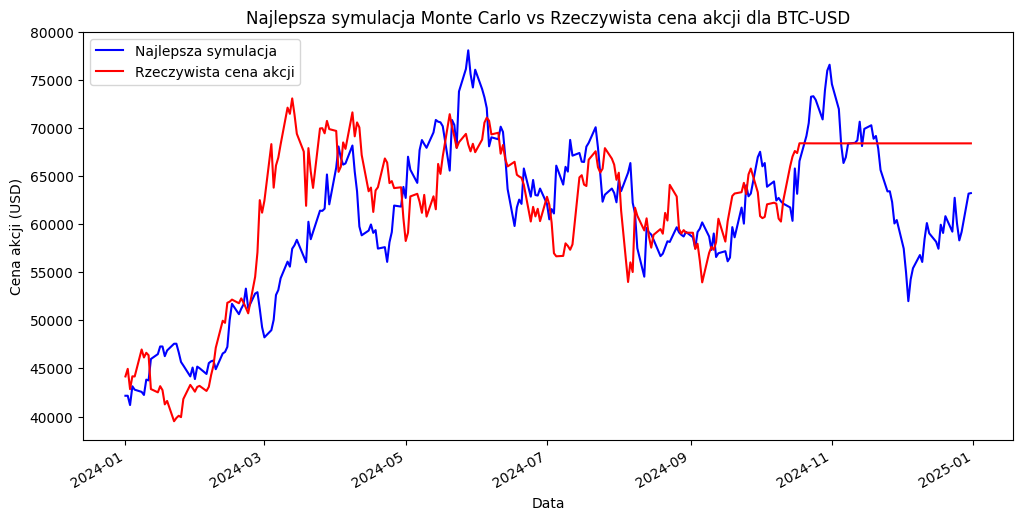

In [49]:
plt.figure(figsize=(12,6))

# Rysowanie wszystkich symulacji (opcjonalnie, dla przejrzystości można pominąć)
# plt.plot(price_list, color='grey', alpha=0.1)
# plt.show()
# Rysowanie najlepszej symulacji
forecast_dates = pd.bdate_range(start=forecast_start_date, end=forecast_end_date)
plt.plot(forecast_dates, best_simulation, color='blue', label='Najlepsza symulacja')

# Rysowanie rzeczywistych cen akcji
plt.plot(forecast_dates, real_prices, color='red', label='Rzeczywista cena akcji')

# Dodanie tytułu i etykiet
plt.title('Najlepsza symulacja Monte Carlo vs Rzeczywista cena akcji dla {}'.format(ticker))
plt.xlabel('Data')
plt.ylabel('Cena akcji (USD)')
plt.legend()

# Ustawienie formatu dat na osi X
plt.gcf().autofmt_xdate()

# Wyświetlenie wykresu
plt.show()

In [50]:
# Tworzenie DataFrame z najlepszą symulacją i rzeczywistymi cenami
comparison = pd.DataFrame({
    'Data': forecast_dates,
    'Najlepsza symulacja': best_simulation,
    'Rzeczywista cena': real_prices
})
comparison.set_index('Data', inplace=True)

# Obliczenie różnicy
comparison['Różnica'] = comparison['Rzeczywista cena'] - comparison['Najlepsza symulacja']

# Wyświetlenie wyników
# print(comparison)

# Obliczenie błędu średniokwadratowego dla najlepszej symulacji
best_mse = errors[best_simulation_index]
print('\nBłąd średniokwadratowy (MSE) dla najlepszej symulacji: {:.2f}'.format(best_mse))



Błąd średniokwadratowy (MSE) dla najlepszej symulacji: 36950213.60
